In [1]:
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import sys, os
sys.path.insert(0, '/'.join(os.path.abspath(os.getcwd()).split('/')[:-1]))
from utils.imports import *
%matplotlib inline

batch_size = 64
learning_rate = 0.01
momentum = 0.5

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed);

In [2]:
test_loader = get_test_loader()
train_loader = get_train_loader(60000)

for (X_train_original, y_train_original) in train_loader:
    pass
for (X_test_original, y_test_original) in test_loader:
    pass

train_loader = get_train_loader(batch_size)
target_label = int(y_test_original[idx_xt])

# Create the torch model and optimizer
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# torch.save(model.state_dict(), '../models/initial_model.pth')
# torch.save(optimizer.state_dict(), '../models/initial_optimizer.pth')


In [3]:
start = time.time()
mc_output0 = []

for _ in range(100):
    ### INPUT:
    num_epochs = 10
    train_losses, train_counter, test_losses, test_counter = [], [], [], []

    # Load initialized parameters 
    random_seed = 42
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed);
    model.load_state_dict(torch.load('../models/initial_model.pth'))
    optimizer.load_state_dict(torch.load('../models/initial_optimizer.pth'))

    for epoch in range(num_epochs):
        s0 = time.time()
        train(model, optimizer, train_loader, train_losses, train_counter, test_loader, test_losses, test_counter, batch_size, epoch)
        print(f'{print_runtime(s0, False)}')
    test(model, test_loader, test_losses, test_counter, epoch+1)
    save_output0(model, idx_xt, X_test_original)
    output0 = load_output0(idx_xt)
    print(f'output0 (at target_label={target_label}) = {output0[target_label]}')
    mc_output0.append(output0)
    print_runtime(start)

/Users/Safak.Ozkan/opt/miniconda3/envs/ic_env/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch: 0   Train_Loss: 0.928461
 (...Runtime: 0 min 15 sec)
epoch: 1   Train_Loss: 0.381892
 (...Runtime: 0 min 12 sec)
epoch: 2   Train_Loss: 0.305286
 (...Runtime: 0 min 13 sec)
epoch: 3   Train_Loss: 0.269158
 (...Runtime: 0 min 12 sec)
epoch: 4   Train_Loss: 0.245182
 (...Runtime: 0 min 13 sec)
epoch: 5   Train_Loss: 0.229114
 (...Runtime: 0 min 13 sec)
epoch: 6   Train_Loss: 0.212335
 (...Runtime: 0 min 14 sec)
epoch: 7   Train_Loss: 0.202805
 (...Runtime: 0 min 13 sec)
epoch: 8   Train_Loss: 0.192346
 (...Runtime: 0 min 13 sec)
epoch: 9   Train_Loss: 0.187437
 (...Runtime: 0 min 14 sec)
idx_xt:5835
output0 saved to ../models/output0_idx_xt5835.npy
output0 = [1.0408091e-02 7.6891665e-05 1.8909460e-01 5.3252596e-03 2.8859792e-02
 4.8975304e-05 7.2395410e-06 4.5442128e-01 2.3666047e-02 2.8809178e-01]
softmax prob = [1.0410e-02 8.0000e-05 1.8909e-01 5.3300e-03 2.8860e-02 5.0000e-05
 1.0000e-05 4.5442e-01 2.3670e-02 2.8809e-01]

--------------------------------------------------------

In [12]:
print(f'{output0[7]}')

0.4544212818145752


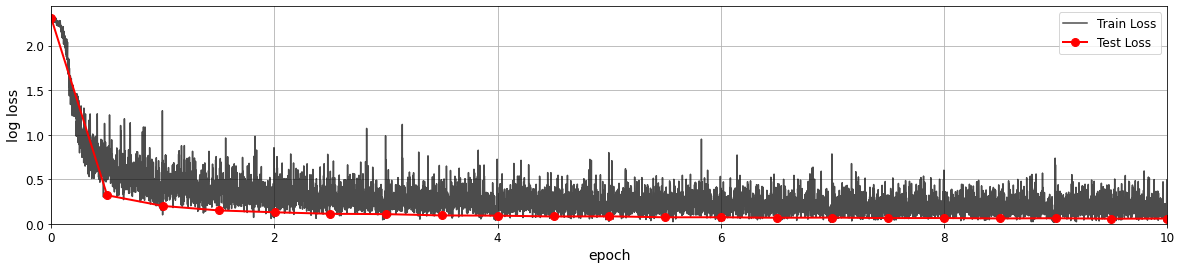

In [4]:
fig = plt.figure(figsize=(20, 4))
plt.plot(train_counter, train_losses, 'k-', alpha=.7)
plt.plot(test_counter, test_losses, 'r.-', linewidth=2, markersize=16)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('epoch', fontsize=14); plt.ylabel('log loss', fontsize=14); plt.xlim(0, train_counter[-1]); plt.ylim(0);

---
## Numerical Gradient Calculator 

In [71]:
""" Numerical Gradient Calculator

        Remove each train samples with label target_label one at a time, 
        then train the pytorch model on remaining 59,999 train samples.
"""

start = time.time()
num_epochs = 8
idx_remove = np.argwhere(y_train_original == target_label)[0]

# Initialize dictionary 'grad'
grad = initialize_grad_dict()    
output0 = load_output0(idx_xt)

for q, ir in enumerate(idx_remove):
    if q < len(grad):
        print(f'skipping q:{q}', end='   ')
        continue
    mask = np.ones(len(X_train_original), dtype=bool)
    mask[ir] = False
    X_train = X_train_original[mask]
    y_train = y_train_original[mask]
    train_losses, train_counter, test_losses, test_counter = [], [], [], []

    random_seed = 42
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed);
    model.load_state_dict(torch.load('../models/initial_model.pth'))
    optimizer.load_state_dict(torch.load('../models/initial_optimizer.pth'))

    for epoch in range(num_epochs):
        train_with_torch_tensors(model, optimizer, train_losses, train_counter, test_loader, test_losses, test_counter,
                                 X_train, y_train, batch_size, epoch)
        
    print(f"\n{q}/{len(idx_remove)-1} finished {print_runtime(start, False)}\n")
    
    model.eval()
    output = np.exp(model(X_test_original[idx_xt:idx_xt+1]).detach().numpy())[0]
    grad[ir.detach().tolist()] = output0 - output
    print(f'grad (at target_label={target_label}) = {grad[ir.detach().tolist()][target_label]}')
    
    if (q+1) % 25 == 0:
        with open('../models/grad_dict.pkl', 'wb') as f:
            pickle.dump(grad, f)


initialized empty dictionary: grad = dict()
output0 = [1.0408091e-02 7.6891665e-05 1.8909460e-01 5.3252596e-03 2.8859792e-02
 4.8975304e-05 7.2395410e-06 4.5442128e-01 2.3666047e-02 2.8809178e-01]
softmax prob = [0.01  0.    0.189 0.005 0.029 0.    0.    0.454 0.024 0.288]

------------------------------------------------------------
epoch: 0   Train_Loss: 0.940199   Test_Loss: 0.196387   Test_Accuracy: 94.05%
epoch: 1   Train_Loss: 0.384402   Test_Loss: 0.129749   Test_Accuracy: 96.17%
epoch: 2   Train_Loss: 0.303265   Test_Loss: 0.103060   Test_Accuracy: 96.84%
epoch: 3   Train_Loss: 0.261440   Test_Loss: 0.089767   Test_Accuracy: 97.25%
epoch: 4   Train_Loss: 0.243121   Test_Loss: 0.081411   Test_Accuracy: 97.53%
epoch: 5   Train_Loss: 0.220124   Test_Loss: 0.075747   Test_Accuracy: 97.64%
epoch: 6   Train_Loss: 0.214626   Test_Loss: 0.067093   Test_Accuracy: 97.85%
epoch: 7   Train_Loss: 0.203827   Test_Loss: 0.063184   Test_Accuracy: 98.01%

0/6264 finished  (...Runtime: 0 min 47 

KeyboardInterrupt: 

---

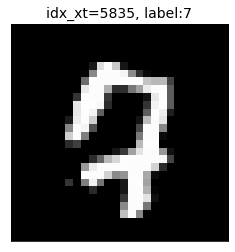

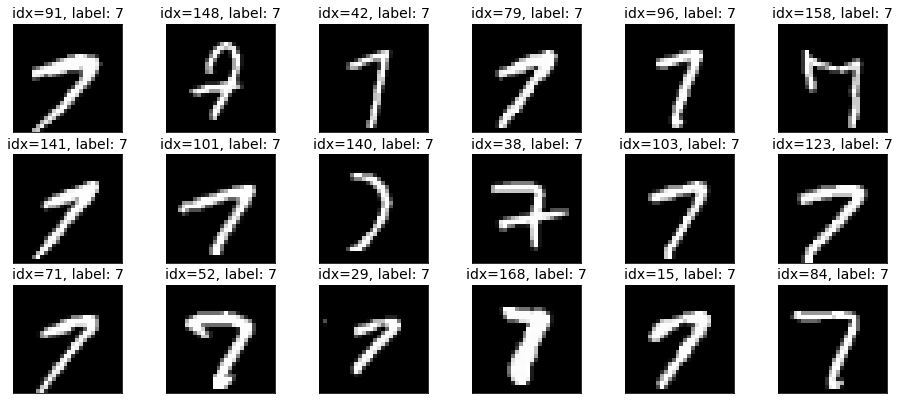

In [31]:
plotter_ranked_sample_importance(X_train_original, X_test_original, target_label, grad)